Model İçin Gerekli Paketlerin Kurulumu

In [ ]:
!pip install chart_studio
!pip install sklearn

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('turkish'))
from bs4 import BeautifulSoup
#from plotly import plotly
import plotly.graph_objs as go
import chart_studio.plotly as py
#import plotly.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

Modeli alacağımız veri kaynağı. Mecvut analizimiz için bir kolonda verinin kendisi, diğer kolonda ise verinin etiketinin bulunması yeterlidir.
text,	labels

	mağazamın ınstagram hesabı için reklam vermeyi...	4
	google şirket reklamı vermek istiyordum bu kon...	2
	ben ınstagram	4
	kolay glsin ben web siteme reklam almak istiyo...	2
	sitemin trafiğini arttırmak için reklam vermey...	0

In [33]:
df = pd.read_csv('veriseti.csv')

In [34]:
#Veri setimize göz atıyoruz.
df.head()

,text,labels
0,mağazamın ınstagram hesabı için reklam vermeyi...,4
1,google şirket reklamı vermek istiyordum bu kon...,2
2,ben ınstagram,4
3,kolay glsin ben web siteme reklam almak istiyo...,2
4,sitemin trafiğini arttırmak için reklam vermey...,0


Veri setimizdeki soruların etiketlere göre dağılımını görmek için veriyi görselleştirme işlemine tabi tutuyoruz.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning:


The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.



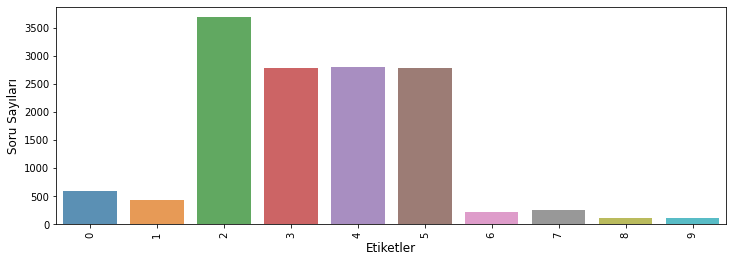

In [35]:
import seaborn as sns
cnt_pro = df['labels'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Soru Sayıları', fontsize=12)
plt.xlabel('Etiketler', fontsize=12)
plt.xticks(rotation=90)
plt.show();

Veri setimizi ön işleme tabi tutarak istenmeyen noktalama işaretleri, büyük harf ve sembollerden arındırıyoruz.

In [36]:

df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('turkish'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # küçük harfe dönüştürür
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text)  
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['text'] = df['text'].apply(clean_text)


Veri setimizi tokenize ediyoruz.

In [ ]:
# Kullanılabilecek maksimum kelime sayısı. 
MAX_NB_WORDS = 50000
# Her defada kullanılabilecek maksimum kelime sayısı.
MAX_SEQUENCE_LENGTH = 250
# Gömü Boyutu(Değiştirmemenizi öneriririz).
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Bulduğumuz tokenlar ile veri setimizin text kısmını n*m lik bir matrise dönüştürüyoruz.

In [ ]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Etiketlerimizi modelimize göre dönüştürüyoruz.

In [ ]:
Y = pd.get_dummies(df['labels']).values
print('Shape of label tensor:', Y.shape)

Eğitim ve test veri setini birbirinden ayırıyoruz.


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

Model parametrelerimizi belirliyoruz.
Son katmanda kaç etiketimiz varsa o kadar çıktı alternatifi oluşturuyoruz. Bizim veri setimizde 10 farklı etiket var bu yüzden dense = 10 dedik. 

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])
print(model.summary())

Belirlediğimiz parametrelere göre modeli eğitiyoruz. Burada öğrenme eğrilerinden modelin en uygun sonucuna göre tekrar modeli baştan eğitmek daha doğru sonuç alabilmemizi mümkün kılar.

In [ ]:
epochs = 20
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Modelin doğruluğunun test seti için ölçümlemesini gerçekleştiriyoruz.

In [44]:
accr = model.evaluate(X_test,Y_test,return_dict=False)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

44/44 [==============================] - 3s 68ms/step - loss: 0.3597 - accuracy: 0.9007 - mse: 0.0149
Test set
  Loss: 0.360
  Accuracy: 0.901


Ürettiğimiz modeli kaydetmek için bunu kullanırız.

In [ ]:
model.save('./model-isminiz/')

Modelin performans metriklerini ölçmek için aşağıdaki kodları kullanıyoruz.

In [ ]:
plt.title('Kayıp Degeri')
plt.plot(history.history['loss'], label='eğitim')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.savefig('LSTM-Loss-LearningCurve.pdf', dpi=1200, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
plt.show();


In [ ]:
plt.title('Doğruluk Öğrenme Eğrisi')
plt.plot(history.history['accuracy'], label='eğitim')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.savefig('LSTM-Accuracy-LearningCurve.pdf', dpi=1200, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
plt.show();

Aşağıda modelin performans analizinin detayları görülmektedir.
Öncelikle, Test setindeki veriler için, soruların gerçek etiketleri ile model tarafından üretilmiş olan etiketleri karşılaştırılır

In [ ]:
y_pred=[]
y_true = []
pred = model.predict(X_test)
for i in range(len(pred)):
  y_pred.append([np.argmax(pred[i])])

for i in range(len(X_test)):
  y_true.append(np.argmax(Y_test[i]))
Y_pred = [item for sublist in y_pred for item in sublist]


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix(y_true, Y_pred)


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, Y_pred))